In [12]:
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [13]:
# Database already separated, so kind
train_df = pd.read_csv("../../dataset/rnn/train.csv")
val_df = pd.read_csv("../../dataset/rnn/valid.csv")
test_df = pd.read_csv("../../dataset/rnn/test.csv")

In [14]:
label_mapping = {"negative": 0,
                 "neutral": 1,
                 "positive": 2
                 }

# Take text and label only
train_df = train_df[["text", "label"]]
val_df = val_df[["text", "label"]]
test_df = test_df[["text", "label"]]

# Warning!!! Not idempotent operations :(
train_df["label"] = train_df["label"].map(label_mapping)
val_df["label"] = val_df["label"].map(label_mapping)
test_df["label"] = test_df["label"].map(label_mapping)

In [15]:
train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()

val_texts = val_df["text"].tolist()
val_labels = val_df["label"].tolist()

test_texts = test_df["text"].tolist()
test_labels = test_df["label"].tolist()

In [16]:
vectorizer = keras.layers.TextVectorization(
    output_mode='int'
)
vectorizer.adapt(train_texts)

In [17]:
x_train = vectorizer(np.array(train_texts))
x_val = vectorizer(np.array(val_texts))
x_test = vectorizer(np.array(test_texts))

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [18]:
embedder = keras.layers.Embedding(
    input_dim=len(vectorizer.get_vocabulary()), 
    output_dim=100
)

In [19]:
x_train_embed = embedder(x_train) 
x_val_embed = embedder(x_val) 
x_test_embed = embedder(x_test) 

In [20]:
from sklearn.metrics import f1_score
from keras.callbacks import Callback
import numpy as np

class F1ScoreCallback(Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val)
        
        # Check if multi-class
        if y_pred.ndim > 1 and y_pred.shape[1] > 1:
            y_pred_labels = np.argmax(y_pred, axis=1)
        else:
            y_pred_labels = (y_pred > 0.5).astype(int).flatten()

        y_true_labels = self.y_val if len(self.y_val.shape) == 1 else np.argmax(self.y_val, axis=1)
        
        f1 = f1_score(y_true_labels, y_pred_labels, average='weighted')
        print(f'Epoch {epoch + 1} - F1 Score: {f1:.4f}\n')

f1_callback = F1ScoreCallback(x_val_embed, y_val)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 390ms/stepep - accuracy: 0.3312 - loss
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3318 - loss: 1.0957 - val_accuracy: 0.3800 - val_loss: 1.0871
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/stepep - accuracy: 0.4032 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 820ms/step - accuracy: 0.4024 - loss: 1.0818 - val_accuracy: 0.3800 - val_loss: 1.0804
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/stepep - accuracy: 0.3895 - loss
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 918ms/step - accuracy: 0.3891 - loss: 1.0828 - val_accuracy: 0.3800 - val_loss: 1.0782
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/stepep - accuracy: 0.3599 - loss
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 893ms/step - accuracy: 0.3610 - loss: 1.0836 - val_accuracy: 0.3800 - val_loss: 1.0794
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/stepep - accuracy: 0.3491 - loss
Epoch 5 - F1 Score: 0.2093

1

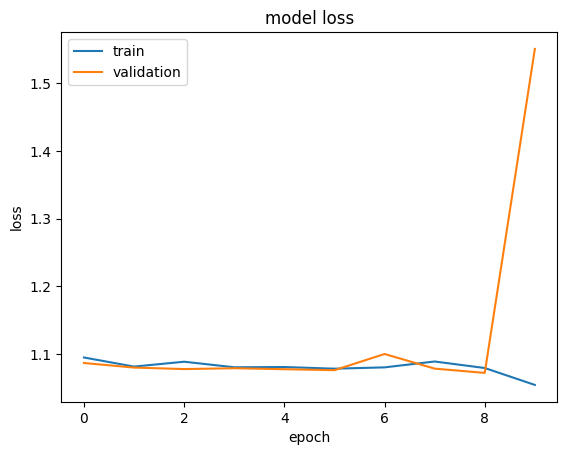

In [ ]:
base = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(3, activation="softmax")
])

base.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history_base = base.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
base.save_weights("base.weights.h5")

# Grafik Loss
plt.plot(history_base.history['loss'])
plt.plot(history_base.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/stepep - accuracy: 0.3382 - loss:
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 786ms/step - accuracy: 0.3395 - loss: 1.0924 - val_accuracy: 0.3800 - val_loss: 1.0807
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/stepep - accuracy: 0.3788 - loss: 
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 513ms/step - accuracy: 0.3791 - loss: 1.0854 - val_accuracy: 0.3800 - val_loss: 1.0813
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/stepep - accuracy: 0.3690 - loss
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 545ms/step - accuracy: 0.3695 - loss: 1.0867 - val_accuracy: 0.3800 - val_loss: 1.0810
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step ep - accuracy: 0.4258 - loss: 1.
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 495ms/step - accuracy: 0.4234 - loss: 1.0742 - val_accuracy: 0.3800 - val_loss: 1.0791
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/stepep - accuracy: 0.3878 - loss: 
Epoch 5 - F1 Score: 

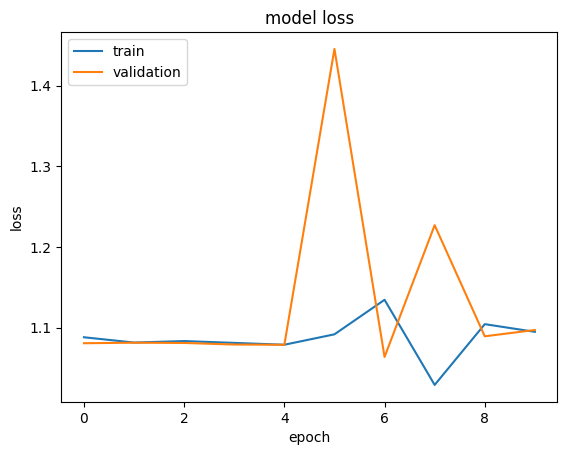

In [ ]:
model1 = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(3, activation="softmax")
])

model1.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history1 = model1.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model1.save_weights("model1.weights.h5")

# Grafik Loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 329ms/stepep - accuracy: 0.3507 - loss
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.3527 - loss: 1.0937 - val_accuracy: 0.3800 - val_loss: 1.0819
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/stepep - accuracy: 0.3607 - loss: 
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 724ms/step - accuracy: 0.3615 - loss: 1.0829 - val_accuracy: 0.3800 - val_loss: 1.0794
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/stepep - accuracy: 0.3848 - loss: 
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 658ms/step - accuracy: 0.3840 - loss: 1.0766 - val_accuracy: 0.3800 - val_loss: 1.0820
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/stepep - accuracy: 0.3859 - loss
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 696ms/step - accuracy: 0.3861 - loss: 1.0810 - val_accuracy: 0.3800 - val_loss: 1.0799
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/stepep - accuracy: 0.3827 - loss
Epoch 5 - F1 Score: 0.209

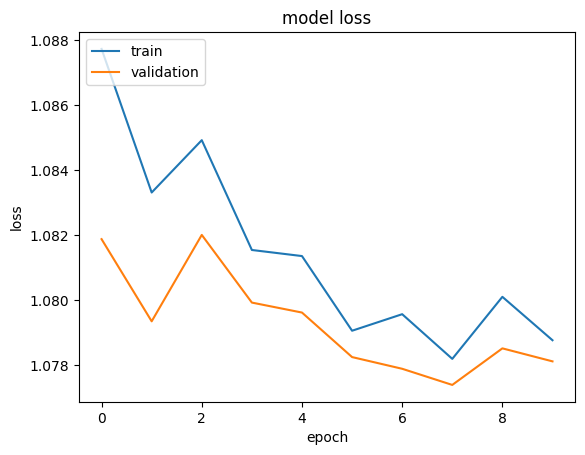

In [23]:
model2 = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256),
    
    keras.layers.Dense(3, activation="softmax")
])

model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history2 = model2.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model2.save_weights("model2.weights.h5")

# Grafik Loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 628ms/step- accuracy: 0.3298 - loss:
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3323 - loss: 1.0984 - val_accuracy: 0.3800 - val_loss: 1.1246
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step- accuracy: 0.3872 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3859 - loss: 1.0842 - val_accuracy: 0.3800 - val_loss: 1.0835
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step- accuracy: 0.3938 - loss
Epoch 3 - F1 Score: 0.3995

16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3938 - loss: 1.0708 - val_accuracy: 0.4800 - val_loss: 1.0211
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step- accuracy: 0.4968 - loss
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4937 - loss: 1.0129 - val_accuracy: 0.3800 - val_loss: 1.0600
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step- accuracy: 0.4169 - loss
Epoch 5 - F1 Score: 0.4449

16/16 ━━━━━━━━━━━━━━━━━━

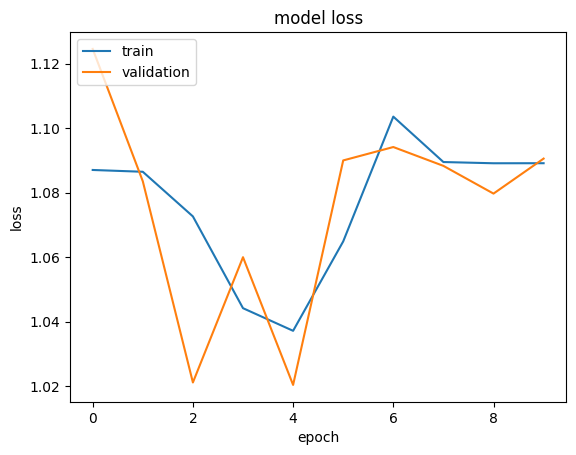

In [24]:
model3 = keras.models.Sequential([
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(256),
    
    keras.layers.Dense(3, activation="softmax")
])

model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history3 = model3.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model3.save_weights("model3.weights.h5")

# Grafik Loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 475ms/step- accuracy: 0.3552 - loss:
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3559 - loss: 1.0907 - val_accuracy: 0.3800 - val_loss: 1.0872
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/stepep - accuracy: 0.3518 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3537 - loss: 1.0900 - val_accuracy: 0.3800 - val_loss: 1.0799
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/stepep - accuracy: 0.3526 - loss
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3520 - loss: 1.0942 - val_accuracy: 0.3800 - val_loss: 1.0778
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/stepep - accuracy: 0.3790 - loss
Epoch 4 - F1 Score: 0.2812

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3782 - loss: 1.0731 - val_accuracy: 0.3900 - val_loss: 1.0806
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/stepep - accuracy: 0.3778 - loss
Epoch 5 - F1 Score: 0.2093

16/16 ━━━━━━

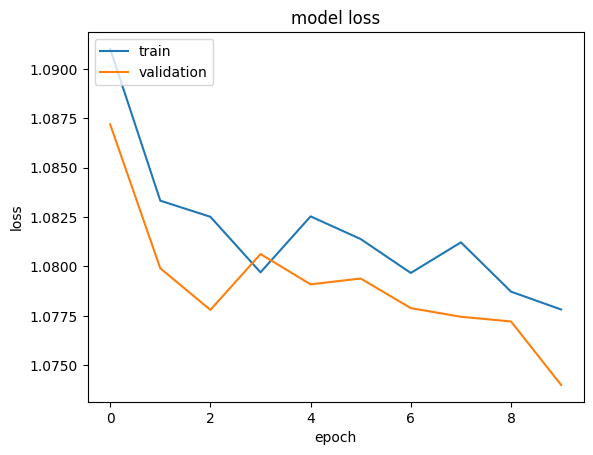

In [25]:
model4 = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(512, return_sequences=True),
    keras.layers.LSTM(256),
    
    keras.layers.Dense(3, activation="softmax")
])

model4.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history4 = model4.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model4.save_weights("model4.weights.h5")

# Grafik Loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/stepep - accuracy: 0.3908 - loss
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 755ms/step - accuracy: 0.3905 - loss: 1.0880 - val_accuracy: 0.3800 - val_loss: 1.0861
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/stepep - accuracy: 0.3874 - loss:
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 465ms/step - accuracy: 0.3871 - loss: 1.0806 - val_accuracy: 0.3800 - val_loss: 1.0792
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/steptep - accuracy: 0.4007 - loss: 1.0
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 477ms/step - accuracy: 0.3998 - loss: 1.0789 - val_accuracy: 0.3800 - val_loss: 1.0759
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/stepep - accuracy: 0.3796 - loss:
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 459ms/step - accuracy: 0.3798 - loss: 1.0723 - val_accuracy: 0.3800 - val_loss: 1.0817
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/stepep - accuracy: 0.3659 - loss
Epoch 5 - F1 Score: 0.

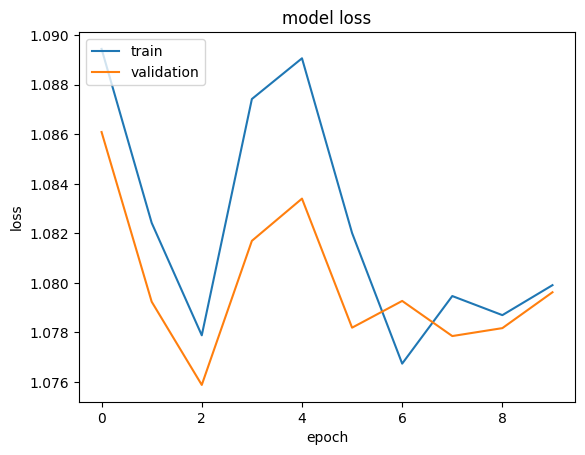

In [26]:
model5 = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(256, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(32),
    
    keras.layers.Dense(3, activation="softmax")
])

model5.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history5 = model5.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model5.save_weights("model5.weights.h5")

# Grafik Loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 460ms/stepep - accuracy: 0.3739 - loss:
Epoch 1 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3739 - loss: 1.0916 - val_accuracy: 0.3800 - val_loss: 1.0867
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/stepep - accuracy: 0.3748 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 801ms/step - accuracy: 0.3743 - loss: 1.0794 - val_accuracy: 0.3800 - val_loss: 1.0821
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/stepep - accuracy: 0.4170 - loss
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 889ms/step - accuracy: 0.4150 - loss: 1.0810 - val_accuracy: 0.3800 - val_loss: 1.0788
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/stepep - accuracy: 0.3712 - loss
Epoch 4 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3709 - loss: 1.0771 - val_accuracy: 0.3800 - val_loss: 1.0809
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step- accuracy: 0.4020 - loss
Epoch 5 - F1 Score: 0.2093

16/16 

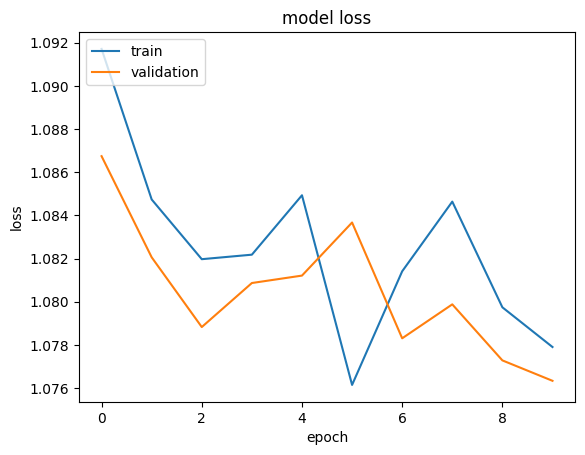

In [27]:
model6 = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(512),
    
    keras.layers.Dense(3, activation="softmax")
])

model6.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history6 = model6.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model6.save_weights("model6.weights.h5")

# Grafik Loss
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step   ep - accuracy: 0.3640 - loss: 
Epoch 1 - F1 Score: 0.3054

16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.3651 - loss: 1.0919 - val_accuracy: 0.4000 - val_loss: 1.0796
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/stepep - accuracy: 0.3617 - loss
Epoch 2 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 728ms/step - accuracy: 0.3614 - loss: 1.0560 - val_accuracy: 0.3800 - val_loss: 1.0869
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/stepep - accuracy: 0.3742 - loss
Epoch 3 - F1 Score: 0.2093

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 576ms/step - accuracy: 0.3745 - loss: 1.0872 - val_accuracy: 0.3800 - val_loss: 1.0790
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/stepep - accuracy: 0.3849 - loss: 
Epoch 4 - F1 Score: 0.2479

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 570ms/step - accuracy: 0.3847 - loss: 1.0730 - val_accuracy: 0.3700 - val_loss: 1.0645
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/stepep - accuracy: 0.4129 - loss
Epoch 5 - F1 Score: 0.3438


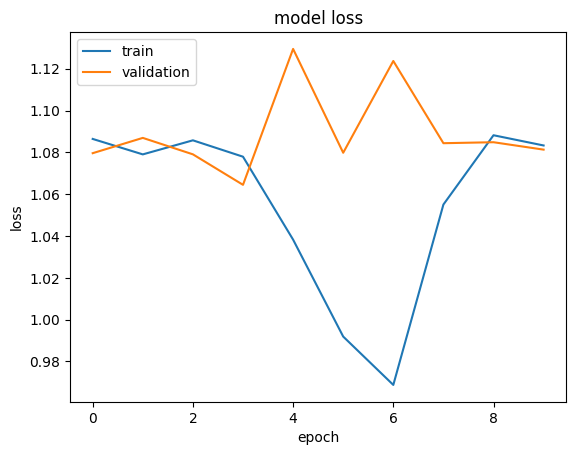

In [28]:
model7 = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64),
    
    keras.layers.Dense(3, activation="softmax")
])

model7.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history7 = model7.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model7.save_weights("model7.weights.h5")

# Grafik Loss
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 980ms/stepep - accuracy: 0.3487 - loss:
Epoch 1 - F1 Score: 0.3780

16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3508 - loss: 1.0735 - val_accuracy: 0.4400 - val_loss: 1.0148
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/stepep - accuracy: 0.4995 - loss
Epoch 2 - F1 Score: 0.4587

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 915ms/step - accuracy: 0.5002 - loss: 0.9483 - val_accuracy: 0.4600 - val_loss: 1.0018
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/stepep - accuracy: 0.5093 - loss
Epoch 3 - F1 Score: 0.4863

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 885ms/step - accuracy: 0.5106 - loss: 0.9344 - val_accuracy: 0.5100 - val_loss: 0.9982
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/stepep - accuracy: 0.5499 - loss
Epoch 4 - F1 Score: 0.5271

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 910ms/step - accuracy: 0.5509 - loss: 0.8249 - val_accuracy: 0.5400 - val_loss: 0.9191
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step- accuracy: 0.5790 - loss
Epoch 5 - F1 Score: 0.5103

16/

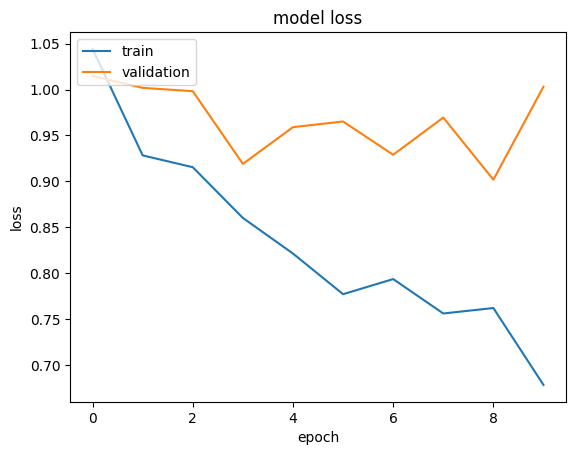

In [29]:
model8 = keras.models.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    
    keras.layers.Dense(3, activation="softmax")
])

model8.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

history8 = model8.fit(
    x_train_embed, 
    y_train, 
    epochs=10, 
    validation_data=(x_val_embed, y_val),
    callbacks=[f1_callback]
)
model8.save_weights("model8.weights.h5")

# Grafik Loss
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()